In [76]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import autocorrelation_plot
from sklearn.metrics import mean_squared_error

## NOTE: The entire dataset is used for time series analysis here, but ideally we would perform this analysis on just the training dataset when developing a predictive model.


In [35]:
from sqlalchemy import create_engine
sqlcon = create_engine('mssql+pyodbc://@' + 'GHOST-117\SQLEXPRESS' + '/' + 'MOHSIN' + '?trusted_connection=yes&driver=ODBC+Driver+13+for+SQL+Server')
# SQL
df = pd.read_sql_query("SELECT [date]      ,[Sales]  FROM [MOHSIN].[dbo].[ARIMA_shampoo2]", sqlcon)


In [36]:
df.head()

,date,Sales
0,2020-01-01,266.0
1,2020-01-02,145.9
2,2020-01-03,183.1
3,2020-01-04,119.3
4,2020-01-05,180.3


         date  Sales
0  2020-01-01  266.0
1  2020-01-02  145.9
2  2020-01-03  183.1
3  2020-01-04  119.3
4  2020-01-05  180.3


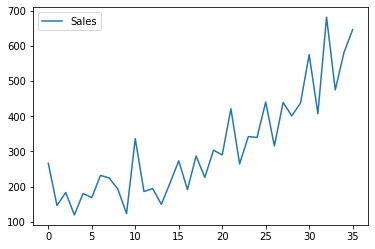

In [37]:
print(df.head())
# special function to easily plot series:
series.plot()



____________

We can see that the Shampoo Sales dataset has a clear trend.

This suggests that the time series is not stationary and will require differencing to make it stationary, at least a difference order of 1.

Let’s also take a quick look at an autocorrelation plot of the time series. 

> An autocorrelation plot is designed to show whether the elements of a time series are positively correlated, negatively correlated, or independent of each other. Used for checking randomness in time series.

This is also built-in to Pandas. The example below plots the autocorrelation for a large number of lags in the time series.

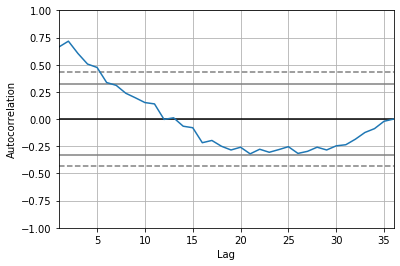

In [38]:
autocorrelation_plot(df.Sales)

Running the example, we can see that there is a positive correlation with the first 10-to-12 lags that is perhaps significant for the first 5 lags.

A good starting point for the AR parameter of the model may be 5.

_________

An ARIMA model can be created using the statsmodels library as follows:

1. Define the model by calling ARIMA() and passing in the p, d, and q parameters.

P = Periods to lag for eg: (if P= 3 then we will use the three previous periods of our time series in the autoregressive portion of the calculation) P helps adjust the line that is being fitted to forecast the series

D = In an ARIMA model we transform a time series into stationary one(series without trend or seasonality) using differencing. D refers to the number of differencing transformations required by the time series to get stationary.

Q = This variable denotes the lag of the error component, where error component is a part of the time series not explained by trend or seasonality


2. The model is prepared on the training data by calling the fit() function.
3. Predictions can be made by calling the predict() function and specifying the index of the time or times to be predicted.

Let’s start off with something simple. We will fit an ARIMA model to the entire Shampoo Sales dataset and review the residual errors.

First, we fit an ARIMA(5,1,0) model. This sets the lag value to 5 for autoregression, uses a difference order of 1 to make the time series stationary, and uses a moving average model of 0.

When fitting the model, a lot of debug information is provided about the fit of the linear regression model. We can turn this off by setting the disp argument to 0.

In [56]:
# fit model
model = ARIMA(df.Sales, order=(5,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())



                             ARIMA Model Results                              
Dep. Variable:                D.Sales   No. Observations:                   35
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -196.170
Method:                       css-mle   S.D. of innovations             64.241
Date:                Mon, 06 Apr 2020   AIC                            406.340
Time:                        09:21:38   BIC                            417.227
Sample:                             1   HQIC                           410.098
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            12.0649      3.652      3.304      0.001       4.908      19.222
ar.L1.D.Sales    -1.1082      0.183     -6.063      0.000      -1.466      -0.750
ar.L2.D.Sales    -0.6203      0.282     

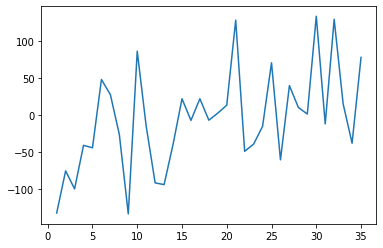

In [58]:
# plot residual errors
residuals = model_fit.resid
residuals.plot()



> ^ a line plot of the residual errors, suggesting that there may still be some trend information not captured by the model.



count     35.000000
mean      -5.495190
std       68.132883
min     -133.296590
25%      -42.477882
50%       -7.186531
75%       24.748366
max      133.237980
dtype: float64


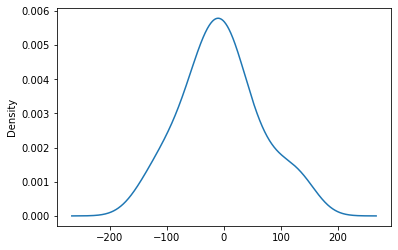

In [59]:
# Plot density of errors:
residuals.plot(kind='kde')
print(residuals.describe())

> ^ The distribution of the residual errors is displayed. The results show that indeed there is a bias in the prediction (a non-zero mean in the residuals).


## Next, let’s look at how we can use the ARIMA model to make forecasts.

We can use the predict() function on the __ARIMAResults__ object to make predictions. It accepts the index of the time steps to make predictions as arguments. These indexes are relative to the start of the training dataset used to make predictions.

If we used 100 observations in the training dataset to fit the model, then the index of the next time step for making a prediction would be specified to the prediction function as start=101, end=101. This would return an array with one element containing the prediction.

We also would prefer the forecasted values to be in the original scale, in case we performed any differencing (d>0 when configuring the model). This can be specified by setting the typ argument to the value ‘levels’: typ=’levels’.

Alternately, we can avoid all of these specifications by using the forecast() function, which performs a one-step forecast using the model.

We can split the training dataset into train and test sets, use the train set to fit the model, and generate a prediction for each element on the test set.

A rolling forecast is required given the dependence on observations in prior time steps for differencing and the AR model. A crude way to perform this rolling forecast is to re-create the ARIMA model after each new observation is received.

We manually keep track of all observations in a list called history that is seeded with the training data and to which new observations are appended each iteration.

Putting this all together, below is an example of a rolling forecast with the ARIMA model in Python.

In [75]:
# convert to numpy array (taking only the Sales column)
X = df2['Sales'].values

X

array([266. , 145.9, 183.1, 119.3, 180.3, 168.5, 231.8, 224.5, 192.8,
       122.9, 336.5, 185.9, 194.3, 149.5, 210.1, 273.3, 191.4, 287. ,
       226. , 303.6, 289.9, 421.6, 264.5, 342.3, 339.7, 440.4, 315.9,
       439.3, 401.3, 437.4, 575.5, 407.6, 682. , 475.3, 581.3, 646.9])

In [78]:

size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
	model = ARIMA(history, order=(5,1,0))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)


predicted=349.117724, expected=342.300000
predicted=306.513044, expected=339.700000
predicted=387.376403, expected=440.400000
predicted=348.154199, expected=315.900000
predicted=386.308847, expected=439.300000
predicted=356.082118, expected=401.300000
predicted=446.379483, expected=437.400000
predicted=394.737306, expected=575.500000
predicted=434.915549, expected=407.600000
predicted=507.923488, expected=682.000000
predicted=435.482867, expected=475.300000
predicted=652.743772, expected=581.300000
predicted=546.343419, expected=646.900000
Test MSE: 6958.324


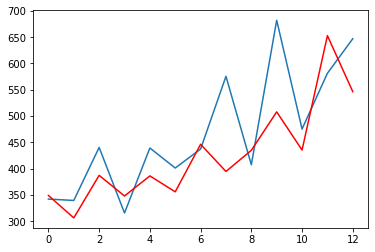

In [82]:
# plot
plt.plot(test)
plt.plot(predictions, color='red')



> A line plot is created showing the expected values (blue) compared to the rolling forecast predictions (red). We can see the values show some trend and are in the correct scale.

The model could use further tuning of the p, d, and maybe even the q parameters. Summary of process to tune the model:

1. __Model Identification.__ Use plots and summary statistics to identify trends, seasonality, and autoregression elements to get an idea of the amount of differencing and the size of the lag that will be required.
2. __Parameter Estimation.__ Use a fitting procedure to find the coefficients of the regression model.
3. __Model Checking.__ Use plots and statistical tests of the residual errors to determine the amount and type of temporal structure not captured by the model.

